Using device: cuda
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 154MB/s]


Epoch 1/20 | Train Loss: 0.5750 | Val Acc: 89.9582%
Epoch 2/20 | Train Loss: 0.3522 | Val Acc: 90.9344%
Epoch 3/20 | Train Loss: 0.3127 | Val Acc: 91.8410%
Epoch 4/20 | Train Loss: 0.2978 | Val Acc: 92.4686%
Epoch 5/20 | Train Loss: 0.2924 | Val Acc: 92.3989%
Epoch 6/20 | Train Loss: 0.1566 | Val Acc: 97.0711%
Epoch 7/20 | Train Loss: 0.0538 | Val Acc: 98.1172%
Epoch 8/20 | Train Loss: 0.0314 | Val Acc: 98.8145%
Epoch 9/20 | Train Loss: 0.0236 | Val Acc: 99.0934%
Epoch 10/20 | Train Loss: 0.0140 | Val Acc: 99.2329%
Epoch 11/20 | Train Loss: 0.0130 | Val Acc: 99.4421%
Epoch 12/20 | Train Loss: 0.0104 | Val Acc: 98.9540%
Epoch 13/20 | Train Loss: 0.0112 | Val Acc: 99.1632%
Epoch 14/20 | Train Loss: 0.0087 | Val Acc: 99.2329%
Epoch 15/20 | Train Loss: 0.0099 | Val Acc: 99.2329%
Epoch 16/20 | Train Loss: 0.0084 | Val Acc: 98.9540%
Epoch 17/20 | Train Loss: 0.0140 | Val Acc: 98.9540%
Epoch 18/20 | Train Loss: 0.0121 | Val Acc: 99.0934%
Epoch 19/20 | Train Loss: 0.0179 | Val Acc: 99.2329%
Ep

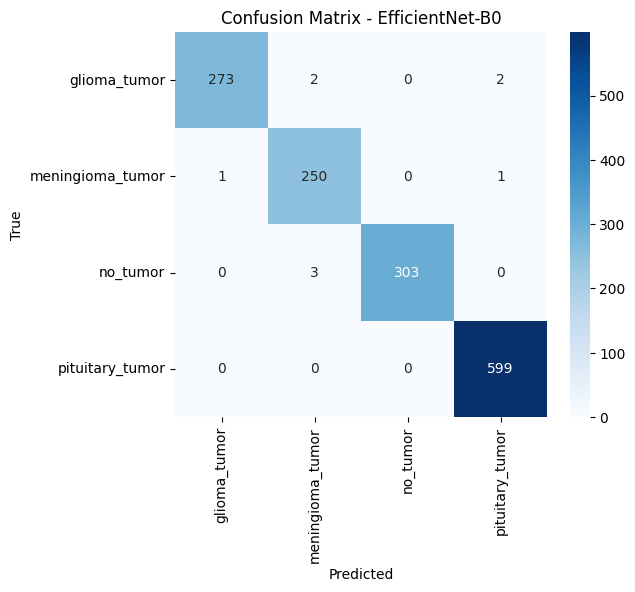


Classification Report (4 decimal precision):
                  precision    recall  f1-score   support

    glioma_tumor     0.9964    0.9856    0.9909       277
meningioma_tumor     0.9804    0.9921    0.9862       252
        no_tumor     1.0000    0.9902    0.9951       306
 pituitary_tumor     0.9950    1.0000    0.9975       599

        accuracy                         0.9937      1434
       macro avg     0.9929    0.9920    0.9924      1434
    weighted avg     0.9938    0.9937    0.9937      1434


Overall Accuracy: 0.9937
✅ Model saved: mri_efficientnet_b0_balanced.pth
✅ Prediction: pituitary_tumor


'pituitary_tumor'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# -------------------------
# 1️⃣ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------
# 2️⃣ Dataset path
data_dir = "/kaggle/input/7k-tumor-dataset/Training"

# -------------------------
# 3️⃣ Transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Extra augmentation for "no_tumor"
no_tumor_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -------------------------
# 4️⃣ Load dataset
full_train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Separate no_tumor dataset (label = 3)
no_tumor_idx = [i for i, label in enumerate(full_train_dataset.targets) if label == 3]
no_tumor_dataset = torch.utils.data.Subset(full_train_dataset, no_tumor_idx)
no_tumor_dataset.dataset.transform = no_tumor_transform

# Combine original + augmented no_tumor
augmented_dataset = ConcatDataset([full_train_dataset, no_tumor_dataset])

# Train/Validation split
train_size = int(0.8 * len(augmented_dataset))
valid_size = len(augmented_dataset) - train_size
train_dataset, valid_dataset = random_split(augmented_dataset, [train_size, valid_size])

# Apply test transform to validation
for ds in valid_dataset.dataset.datasets:
    ds.transform = test_transform

# -------------------------
# 5️⃣ WeightedRandomSampler for train_dataset
def get_targets_from_concatdataset(subset):
    targets = []
    for idx in subset.indices:
        if idx < len(subset.dataset.datasets[0]):  # from full_train_dataset
            targets.append(subset.dataset.datasets[0].targets[idx])
        else:  # from no_tumor_dataset subset
            offset = idx - len(subset.dataset.datasets[0])
            sample_idx = subset.dataset.datasets[1].indices[offset]
            targets.append(subset.dataset.datasets[1].dataset.targets[sample_idx])
    return targets

train_targets = get_targets_from_concatdataset(train_dataset)

class_counts = np.bincount(train_targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in train_targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# -------------------------
# 6️⃣ Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=32)

class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
print("Classes:", class_names)

# -------------------------
# 7️⃣ Model: EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))
model = model.to(device)

# Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# -------------------------
# 8️⃣ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# -------------------------
# 9️⃣ Training loop
num_epochs = 20
unfreeze_at = 5

for epoch in range(num_epochs):
    # Unfreeze backbone after few epochs
    if epoch == unfreeze_at:
        for param in model.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}%")

# -------------------------
# 🔟 Evaluation: Confusion Matrix
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - EfficientNet-B0")
plt.show()

print("\nClassification Report (4 decimal precision):")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

acc = accuracy_score(all_labels, all_preds)
print(f"\nOverall Accuracy: {acc:.4f}")

# -------------------------
# 1️⃣1️⃣ Save Model
torch.save(model.state_dict(), "/kaggle/working/mri_efficientnet_b0_balanced.pth")
print("✅ Model saved: mri_efficientnet_b0_balanced.pth")

# -------------------------
# 🔹 Prediction Function
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = test_transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)
    
    predicted_class = class_names[pred.item()]
    print(f"✅ Prediction: {predicted_class}")
    return predicted_class

# Example usage
test_image = "/kaggle/input/7k-tumor-dataset/Testing/pituitary/Te-piTr_0001.jpg"
predict_image(test_image)


In [10]:
torch.save(model.state_dict(), "/kaggle/working/mri_resnet18_balanced.pth")
print("Model saved!")


Model saved!


In [3]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:0000:0100:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB

🧠 Predicted Class: pituitary_tumor


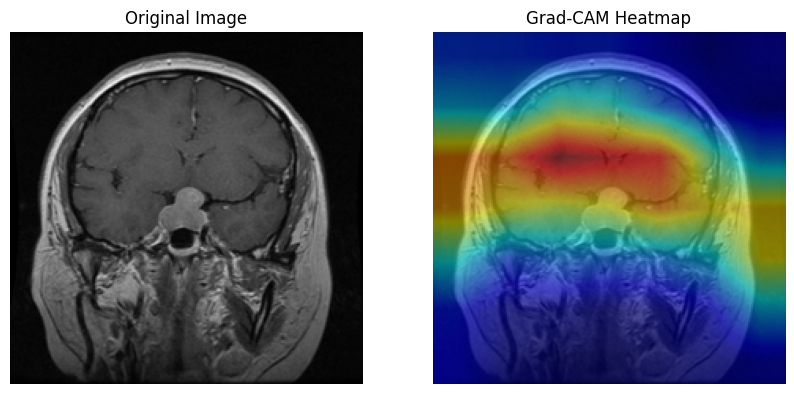

In [15]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# -------------------------
# Device (GradCAM works best on CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Class names
class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# -------------------------
# Load trained EfficientNet-B0
model = models.efficientnet_b0(pretrained=False)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))

model.load_state_dict(torch.load("/kaggle/working/mri_efficientnet_b0_balanced.pth", map_location="cpu"))
model = model.cpu()
model.eval()

# -------------------------
# Transform
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -------------------------
# Grad-CAM target layer (last conv block)
target_layer = model.features[-1]

cam = GradCAM(model=model, target_layers=[target_layer])

# -------------------------
# Prediction + Grad-CAM
def visualize_efficientnet_gradcam(image_path):
    image = Image.open(image_path).convert("RGB")
    rgb_img = np.array(image.resize((224,224))) / 255.0
    input_tensor = test_transform(image).unsqueeze(0)

    # Prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        pred_class = torch.argmax(outputs, 1).item()
        predicted_label = class_names[pred_class]

    print(f"🧠 Predicted Class: {predicted_label}")

    # Grad-CAM
    if predicted_label != "no_tumor":
        targets = [ClassifierOutputTarget(pred_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        # Normalize heatmap
        grayscale_cam = np.maximum(grayscale_cam, 0)
        grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() + 1e-8)

        visualization = show_cam_on_image(
            rgb_img,
            grayscale_cam,
            colormap=cv2.COLORMAP_JET,
            use_rgb=True
        )
    else:
        visualization = rgb_img

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(visualization)
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis("off")

    plt.show()

# -------------------------
# Test
test_image = "/kaggle/input/7k-tumor-dataset/Testing/pituitary/Te-piTr_0001.jpg"
visualize_efficientnet_gradcam(test_image)
